In [6]:
import pickle
import warnings

import dpctl
import numpy as np
import pandas as pd
from numba import jit, njit
# cimport pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import PassiveAggressiveRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearnex import patch_sklearn
from sklearnex._device_offload import _get_device_info_from_daal4py
from sklearnex.ensemble import RandomForestRegressor as rfe
from sklearnex.model_selection import train_test_split

In [13]:
# df = pd.read_csv("data/data.csv", index_col=0)
# df["missing_cols"] = df.isna().sum(axis=1)

# def compress(_df: pd.DataFrame):
#     fl = _df.select_dtypes(include="float64")
#     ins = _df.select_dtypes(include="int64")
#     for c in fl:
#         _df[c] = _df[c].astype(np.float32)
#     for c in ins:
#         _df[c] = _df[c].astype(np.uint8)
#     return _df

In [77]:
# df = compress(df)
import os

os.environ["NUMBA_PARALLEL_DIAGNOSTICS"] = "0"
os.environ["CC"] = "icx"
os.environ["CXX"] = "icpx"

In [2]:
def conn():
    with open("data.pkl", "rb") as fp:
        dpkl = pickle.load(fp)
    return dpkl


class DB:
    def __init__(self):
        self.df: pd.DataFrame = conn()
        self.df: np.ndarray = self.df.to_numpy()
        self.msd: np.array = self.pkload("missing_data").to_numpy()
        # removing the missing_cols

    @staticmethod
    def sv(data: pd.DataFrame, name: str):
        with open(f"{name}.pkl", "wb+") as fp:
            pickle.dump(data, fp)

    @staticmethod
    def pkload(fn):
        with open(fn + ".pkl", "rb") as fp:
            data = pickle.load(fp)
        return data


if __name__ == "__main__":
    pass

In [3]:
d = DB()

In [22]:
# one feature missing
ofm_idx = np.where(d.msd == 1)[0]

In [23]:
clean_idx = np.where(d.msd == 0)[0]

In [24]:
pristine = d.ndf[clean_idx, :]

## Main

In [60]:
X_ = d.df
# missings = X_[:, 80]


@njit(parallel=True)
def data_n_miss(n, x=X_):
    # data with x features simultaneously missing
    t = x[:, 80]
    idx = np.where(t == n)[0]
    return x[idx, :80]


@njit(parallel=True)
def feat_n_miss(n, cc, x=X_):
    # Index of incomplete features
    feed: np.ndarray = np.isnan(cc).sum(axis=0)
    feat_idx = np.where(feed > 0)[0]
    return feat_idx


@njit(parallel=True)
def feat_x_nan_idx(feature, cc):
    # cc data_n_miss
    # return the indices of data missing "x" feature
    cl_ = cc[:, feature]
    return np.where(np.isnan(cl_))[0]


# clean data
dcl = data_n_miss(0)
dcl_1 = data_n_miss(1)

#### Values Missing Per Column for records with exactly "N" col missing

In [24]:
@jit(parallel=True)
def find_total_missing_per_col(n):
    df = data_n_miss(n)
    null = np.isnan(df).sum(axis=0)
    return null

In [35]:
find_total_missing_per_col(9)

array([1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1])

In [12]:
feat_n_miss(1, data_n_miss(1))

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 40, 41,
       42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58,
       59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75,
       76, 77, 78, 79])

In [145]:
c = 1  # col_id
n = 1  # num_col_missing
ms = data_n_miss(n)
fs = feat_n_miss(n, ms)

In [77]:
import seaborn as sns

k = np.isnan(ms).sum(axis=0)
sns.lineplot(x=list(range(80)), y=k)

<AxesSubplot:>

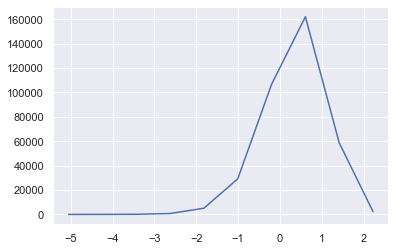

In [133]:
_y_, _x_ = np.histogram(dcl[:, 12])
sns.lineplot(x=_x_[1:], y=_y_)

In [155]:
models = {}
# F_1_0 to F_1_14
# F_2_0 to F_2_24
# F_3_0 to F_3_24
# F_4_0 to F_4_14

# build clean models
def clean_model(f_: int, dcl=dcl):
    pass


# build dirty models
def dirty_models(f_: int, ms=ms):
    pass

<AxesSubplot:>

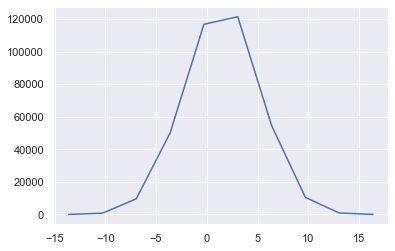

In [160]:
k = dcl[:, :14].sum(axis=1)
# sns.lineplot(x=list(range(k.shape[0])), y=k)
_y_, _x_ = np.histogram(k)
bsns.lineplot(x=_x_[1:], y=_y_)

In [37]:
import gc
import pickle

import dpctl
import numpy as np
from joblib import parallel_backend
from sklearn.feature_selection import SelectKBest, SelectPercentile, SequentialFeatureSelector, mutual_info_regression
from sklearn.linear_model import (
    ARDRegression,
    BayesianRidge,
    ElasticNet,
    GammaRegressor,
    Lasso,
    LassoLars,
    LassoLarsIC,
    LinearRegression,
    MultiTaskElasticNet,
    MultiTaskLasso,
    PassiveAggressiveRegressor,
    PoissonRegressor,
    QuantileRegressor,
    RANSACRegressor,
    SGDRegressor,
    TheilSenRegressor,
    TweedieRegressor,
)
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PowerTransformer, QuantileTransformer, StandardScaler
from sklearn.svm import SVR, LinearSVR, NuSVR
from sklearnex import patch_sklearn
from tqdm import tqdm


def conn():
    with open("data_np.pkl", "rb") as fp:
        dpkl = pickle.load(fp)
    return dpkl


import warnings

warnings.filterwarnings("ignore")

# cdef np.ndarray X__ = conn()
X__ = conn()

patch_sklearn()


def data_n_miss(n):
    # data with x features simultaneously missing
    # cdef np.ndarray t, idx
    t = X__[:, 80]
    idx = np.where(t == n)[0]
    return X__[idx, :80]


ms = data_n_miss(1)
dcl = data_n_miss(0)

iter_ = 10000
tol = 0.000001

estimators = [
    LassoLarsIC(normalize=False, precompute=True, criterion="bic"),
    # # LinearRegression(),
    # # SGDRegressor(learning_rate='adaptive'),
    # # ARDRegression(n_iter=1000,compute_score=True,tol=tol),
    BayesianRidge(lambda_init=0.001, n_iter=iter_, tol=tol, compute_score=True),
    # # PassiveAggressiveRegressor(C=0.5, max_iter=iter_,tol=tol,early_stopping=True,validation_fraction=0.3,n_iter_no_change=20),
    # # LinearSVR(tol=tol,max_iter=iter_,random_state=0,C=0.5),
    # # NuSVR(kernel='linear',tol=tol),
    # # SVR(kernel='poly',tol=tol),
    Lasso(precompute=True, max_iter=iter_, tol=tol, selection="random"),
    LassoLars(precompute=True, max_iter=iter_),
    RANSACRegressor(
        min_samples=500, base_estimator=LassoLars(precompute=True, max_iter=iter_, random_state=0), max_trials=10000
    ),
    # # TheilSenRegressor(n_jobs=-1),
    ElasticNet(
        precompute=True,
    ),
    # MultiTaskElasticNet(random_state=0),
    # MultiTaskLasso(random_state=0)
]

tweed_estimators = [
    TweedieRegressor(power=0),
    TweedieRegressor(power=1),
    TweedieRegressor(power=1.5),
    TweedieRegressor(power=2),
    TweedieRegressor(power=3),
]


def feat_n_miss():
    # Col Index of incomplete features
    # cdef np.ndarray feed, feat_idx
    global ms
    feed: np.ndarray = np.isnan(ms).sum(axis=0)
    feat_idx = np.where(feed > 0)[0]
    return feat_idx


def feat_x_nan_idx(feature, cc):
    # cc data_n_miss
    # return the indices of data missing "x" feature
    cl_ = cc[:, feature]
    return np.where(np.isnan(cl_))[0]


# # clean data


def get_clean_data(target_f, dirty_f_idx, size=0.5):
    clash = np.array([target_f, dirty_f_idx])
    d_features = np.setdiff1d(np.arange(80), clash)
    test_f = dcl[:, d_features]
    test_t = dcl[:, target_f]
    xt, xst, yt, yst = train_test_split(test_f, test_t, test_size=size, random_state=0, shuffle=True)
    return xt, yt


from collections import defaultdict


def clean_learning(target_f, size=0.7, exx=estimators):
    global clean_results

    d_features = np.setdiff1d(np.arange(80), np.array(target_f))
    xf = dcl[:, d_features]
    yf = dcl[:, target_f]
    X_train, X_test, y_train, y_test = train_test_split(xf, yf, test_size=size, random_state=0, shuffle=True)

    for e in tqdm(exx):
        with parallel_backend("loky"):
            e.fit(X_train, y_train)
            y_pred = e.predict(X_test)
            safer = gc.collect()
            clean_results[target_f][e.__class__.__name__] = mean_squared_error(y_pred, y_test)
            safer = gc.collect()


def dirty_df(target_f, dirty_f_idx, ms=ms):
    # dirty_f_idx.append(target_f)
    clash = np.array([target_f, dirty_f_idx])
    # cdef np.ndarray clash
    d_features = np.setdiff1d(np.arange(80), clash)
    dirty_f_training_data_idx = feat_x_nan_idx(dirty_f_idx, ms)
    ark = ms[dirty_f_training_data_idx, :]
    ark = ark[:, d_features]
    ark_target = ms[dirty_f_training_data_idx, target_f]
    return ark, ark_target


# # @jit(parallel=True)
def roll(target_f, dirty_f_idx):
    global estimators
    dirty_results[target_f][dirty_f_idx] = {}
    x_train, y_train = dirty_df(target_f, dirty_f_idx)
    X_train, X_test, y_train, y_test = train_test_split(xf, yf, test_size=size, random_state=0, shuffle=True)
    safer = gc.collect()
    # workflow = make_pipeline((), estimator)
    xtest, ytest = get_clean_data(target_f, dirty_f_idx)
    with dpctl.device_context("gpu"):

        for est in estimators:
            with parallel_backend("loky", n_jobs=-1):
                # print("="*30+f"{workflow.__class__.__name__} started"+"="*30)
                # workflow = make_pipeline(PowerTransformer(),
                #                          # SequentialFeatureSelector(n_features_to_select=0.8,cv=5,estimator=ElasticNet(precompute=True),direction='backward',n_jobs=-1),
                #                          SelectPercentile(mutual_info_regression,percentile=50),
                #                          est, memory='learning/')
                workflow = est
                workflow.fit(x_train, y_train)
                y_pred = workflow.predict(xtest)
                safer = gc.collect()
                dirty_results[target_f][dirty_f_idx][est.__class__.__name__] = mean_squared_error(y_pred, ytest)
                # print(workflow.__class__.__name__,":",mean_squared_error(y_pred, ytest))

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [38]:
gc.collect()

0

In [34]:
import pandas as pd

pd.DataFrame(dirty_results[5]).rank()

""


In [25]:
# # from tqdm.notebook import trange, tqdm# g = feat_n_miss()
g = feat_n_miss()
yu = 6
for i in tqdm(g[\0]):
    # clean_learning(i)
    if i!=yu:
        roll(yu,i)
import pandas as pd

pd.DataFrame(dirty_results[6]).rank().mean(axis=1)
# roll(0,1)
# clean_results

100%|███████████████████████████████████████████| 55/55 [12:55<00:00, 14.10s/it]


LassoLarsIC        2.740741
BayesianRidge      4.759259
Lasso              2.740741
LassoLars          2.740741
RANSACRegressor    5.277778
ElasticNet         2.740741
dtype: float64

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>], dtype=object)

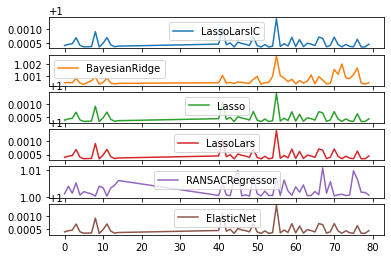

In [26]:
drd = pd.DataFrame(dirty_results[6])
drd.T.plot(kind="line", subplots=True)

In [37]:
mod = ["LassoLarsIC", "ARDRegression", "BayesianRidge", "Lasso", "LassoLars", "RANSACRegressor", "ElasticNet"]

In [71]:
mod = ["LassoLarsIC", "ARDRegression", "BayesianRidge", "Lasso", "LassoLars", "RANSACRegressor", "ElasticNet"]
co = ["b", "r", "g", "m"]
e = drd.rank()

AttributeError: 'numpy.ndarray' object has no attribute 'show'

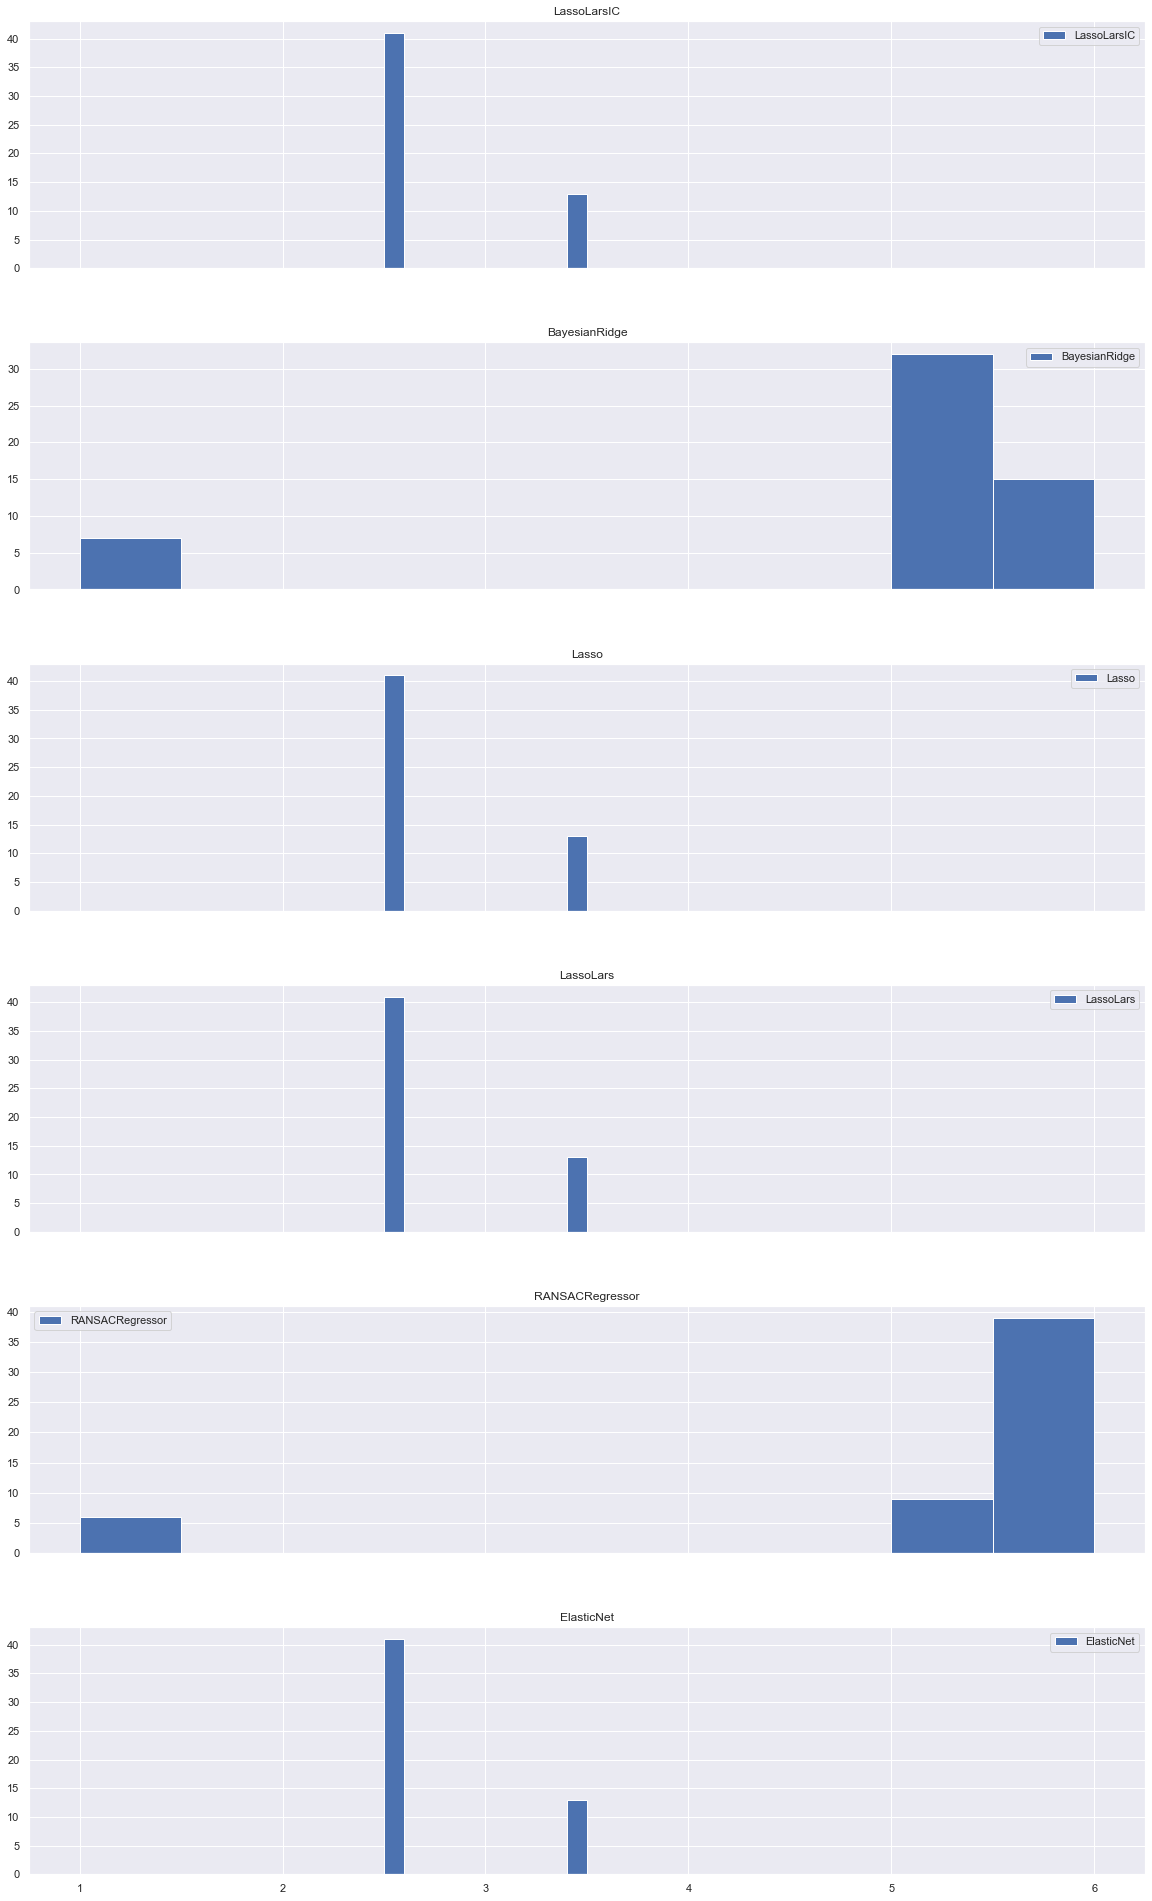

In [31]:
sns.set()
pd.options.plotting.backend = "matplotlib"
fig1 = drd.rank().T.hist(figsize=(20, 40), layout=(7, 1), sharex=True, legend=True)
# fig1.show()
# fig1.show()
# e.T.hist()

In [39]:
clean_learning(6)

100%|█████████████████████████████████████████████| 6/6 [01:04<00:00, 10.77s/it]


In [30]:
import seaborn as sns

In [40]:
clean_results

defaultdict(dict,
            {6: {'LassoLarsIC': 1.0013853,
              'BayesianRidge': 1.0013888165670553,
              'Lasso': 1.0013853,
              'LassoLars': 1.0013853,
              'RANSACRegressor': 1.0039965,
              'ElasticNet': 1.0013853}})

In [41]:
pd.options.display.max_columns = 90
pd.options.display.max_rows = 90

In [43]:
pd.DataFrame(drd)

,0,1,2,3,4,5,7,8,9,10,11,12,13,14,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79
LassoLarsIC,1.000399,1.000441,1.000465,1.000690,1.000403,1.000348,1.000360,1.000913,1.000344,1.000481,1.000696,1.000426,1.000354,1.000376,1.000451,1.001067,1.000424,1.000497,1.000343,1.000524,1.000474,1.000444,1.000401,1.000715,1.000398,1.000344,1.000436,1.000344,1.000374,1.001393,1.000363,1.000467,1.000381,1.000705,1.000361,1.000617,1.000355,1.000482,1.000449,1.000397,1.000710,1.000666,1.000350,1.000406,1.000711,1.000436,1.000347,1.000441,1.000368,1.000348,1.000630,1.000346,1.000347,1.000446
BayesianRidge,1.000465,1.000485,1.000459,1.000815,1.000430,1.000340,1.000625,1.000926,1.000353,1.000485,1.000833,1.000446,1.000363,1.000413,1.000466,1.001061,1.000434,1.000495,1.000403,1.000523,1.000499,1.000439,1.000422,1.000757,1.000973,1.000349,1.000465,1.000493,1.000976,1.002622,1.001031,1.000837,1.000550,1.000742,1.000378,1.000635,1.000439,1.000588,1.001093,1.000375,1.000962,1.000680,1.000374,1.000431,1.001539,1.001145,1.001973,1.000865,1.000796,1.001124,1.001651,1.000432,1.000358,1.000468
Lasso,1.000399,1.000441,1.000465,1.000690,1.000403,1.000348,1.000360,1.000913,1.000344,1.000481,1.000696,1.000426,1.000354,1.000376,1.000451,1.001067,1.000424,1.000497,1.000343,1.000524,1.000474,1.000444,1.000401,1.000715,1.000398,1.000344,1.000436,1.000344,1.000374,1.001393,1.000363,1.000467,1.000381,1.000705,1.000361,1.000617,1.000355,1.000482,1.000449,1.000397,1.000710,1.000666,1.000350,1.000406,1.000711,1.000436,1.000347,1.000441,1.000368,1.000348,1.000630,1.000346,1.000347,1.000446
LassoLars,1.000399,1.000441,1.000465,1.000690,1.000403,1.000348,1.000360,1.000913,1.000344,1.000481,1.000696,1.000426,1.000354,1.000376,1.000451,1.001067,1.000424,1.000497,1.000343,1.000524,1.000474,1.000444,1.000401,1.000715,1.000398,1.000344,1.000436,1.000344,1.000374,1.001393,1.000363,1.000467,1.000381,1.000705,1.000361,1.000617,1.000355,1.000482,1.000449,1.000397,1.000710,1.000666,1.000350,1.000406,1.000711,1.000436,1.000347,1.000441,1.000368,1.000348,1.000630,1.000346,1.000347,1.000446
RANSACRegressor,1.001229,1.004034,1.001422,1.005307,1.000744,1.002008,1.001150,1.000354,1.004044,1.003496,1.000360,1.003373,1.004386,1.006161,1.000609,1.005073,1.000769,1.000531,1.006553,1.009793,1.000450,1.000819,1.000355,1.007670,1.001218,1.000436,1.002232,1.000588,1.000578,1.006635,1.000585,1.006356,1.002285,1.000628,1.003836,1.001849,1.004538,1.000542,1.000599,1.002070,1.000890,1.010876,1.001448,1.005713,1.000400,1.000867,1.001027,1.000562,1.000768,1.009780,1.006662,1.001756,1.001723,1.000717
ElasticNet,1.000399,1.000441,1.000465,1.000690,1.000403,1.000348,1.000360,1.000913,1.000344,1.000481,1.000696,1.000426,1.000354,1.000376,1.000451,1.001067,1.000424,1.000497,1.000343,1.000524,1.000474,1.000444,1.000401,1.000715,1.000398,1.000344,1.000436,1.000344,1.000374,1.001393,1.000363,1.000467,1.000381,1.000705,1.000361,1.000617,1.000355,1.000482,1.000449,1.000397,1.000710,1.000666,1.000350,1.000406,1.000711,1.000436,1.000347,1.000441,1.000368,1.000348,1.000630,1.000346,1.000347,1.000446
